In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})


In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

def generate_noise_fixed(key, N_particles):
    """Generate fixed noise for reproducible results"""
    keys = random.split(key, 6)
    noise = jnp.column_stack([
        random.uniform(keys[0], shape=(N_particles,)),  # r
        random.uniform(keys[1], shape=(N_particles,)),  # phi
        random.uniform(keys[2], shape=(N_particles,)),  # sin_i  
        random.uniform(keys[3], shape=(N_particles,)),  # u
        random.uniform(keys[4], shape=(N_particles,)),  # phi_v
        random.uniform(keys[5], shape=(N_particles,))   # sin_i_v
    ])
    return noise


key = random.PRNGKey(1)

#set up the particles in the initial state
# positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)
noise = generate_noise_fixed(key, config.N_particles)
positions, velocities, mass = Plummer_sphere_reparam(noise=noise, params=params, config=config)




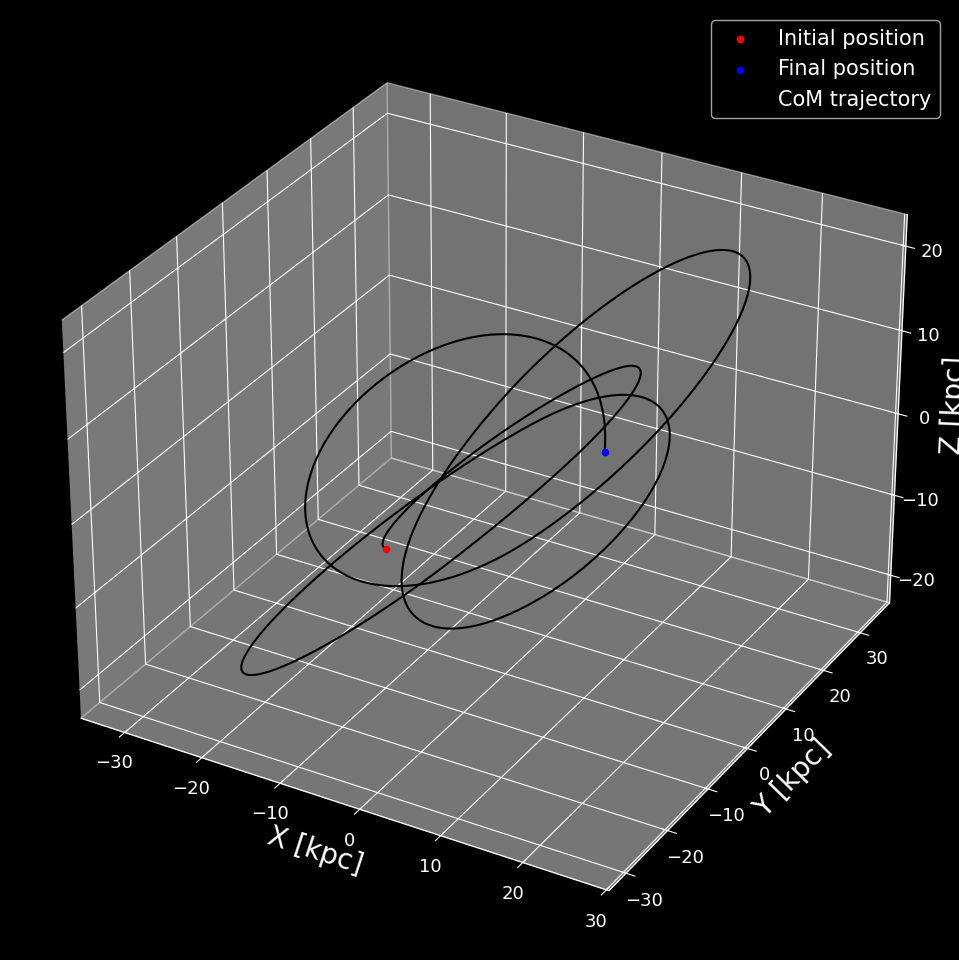

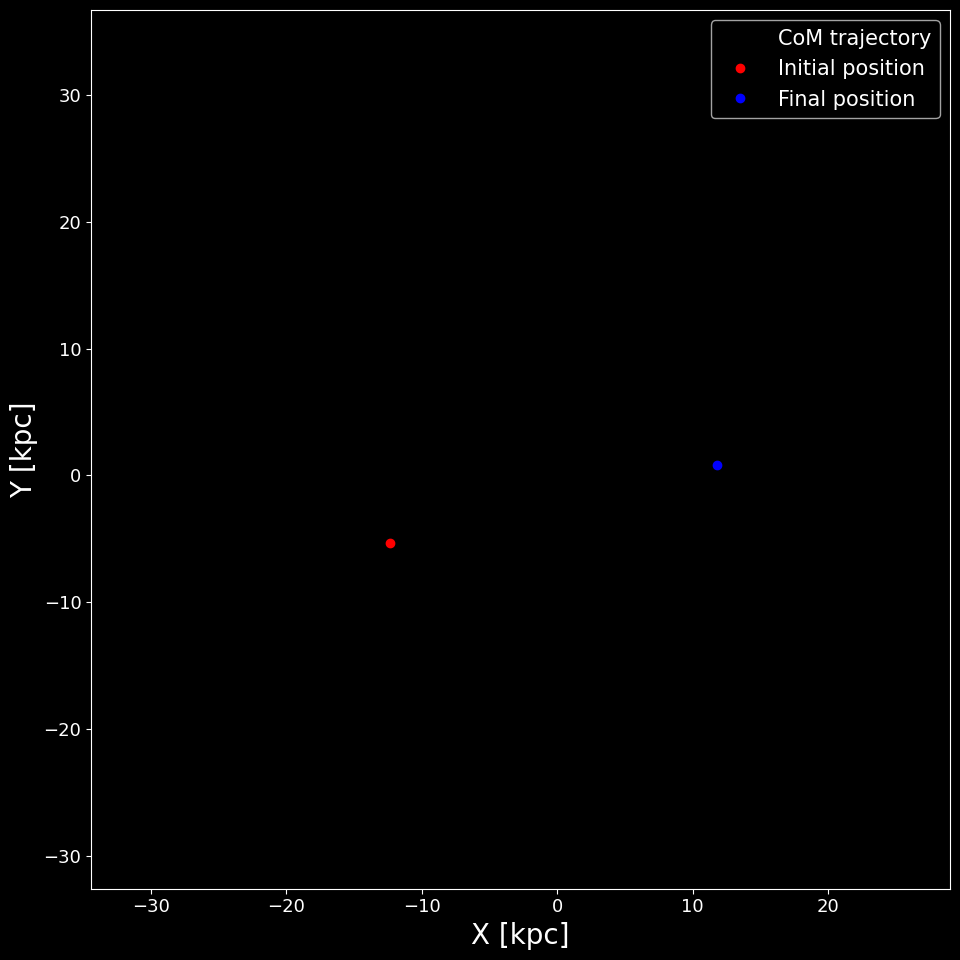

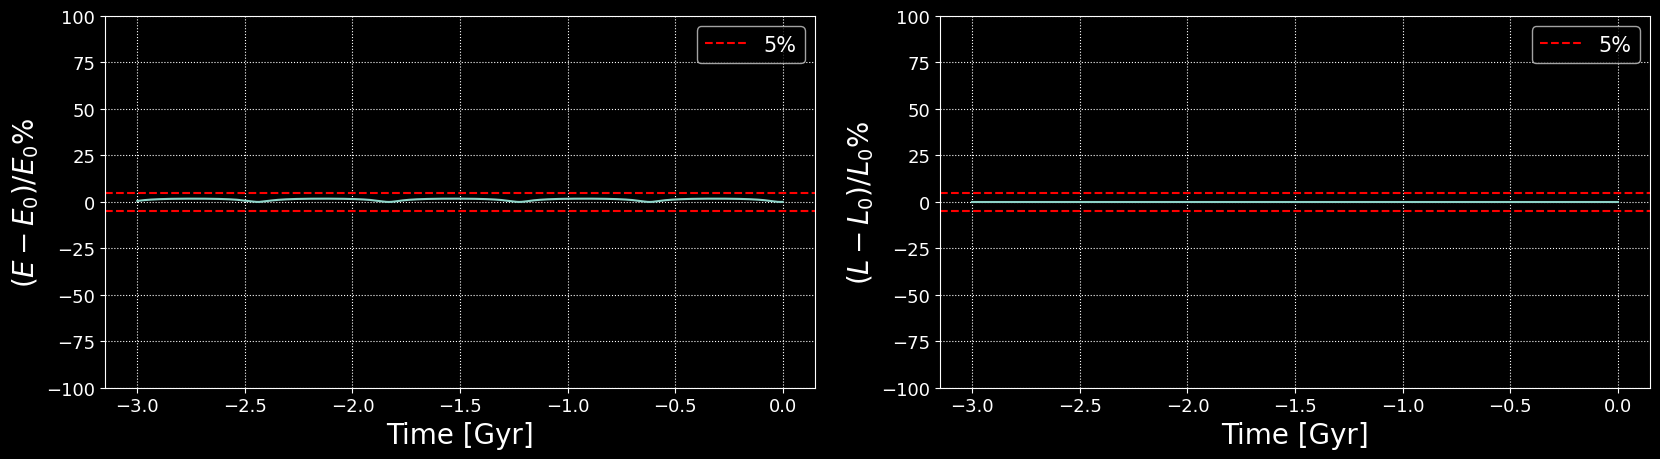

In [3]:

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
# config_com = config._replace(return_snapshots=True,)
# config_com = config._replace(num_snapshots=500, )
params_com = params._replace(t_end=-params.t_end,)



#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

In [2]:
#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

NameError: name 'time_integration' is not defined

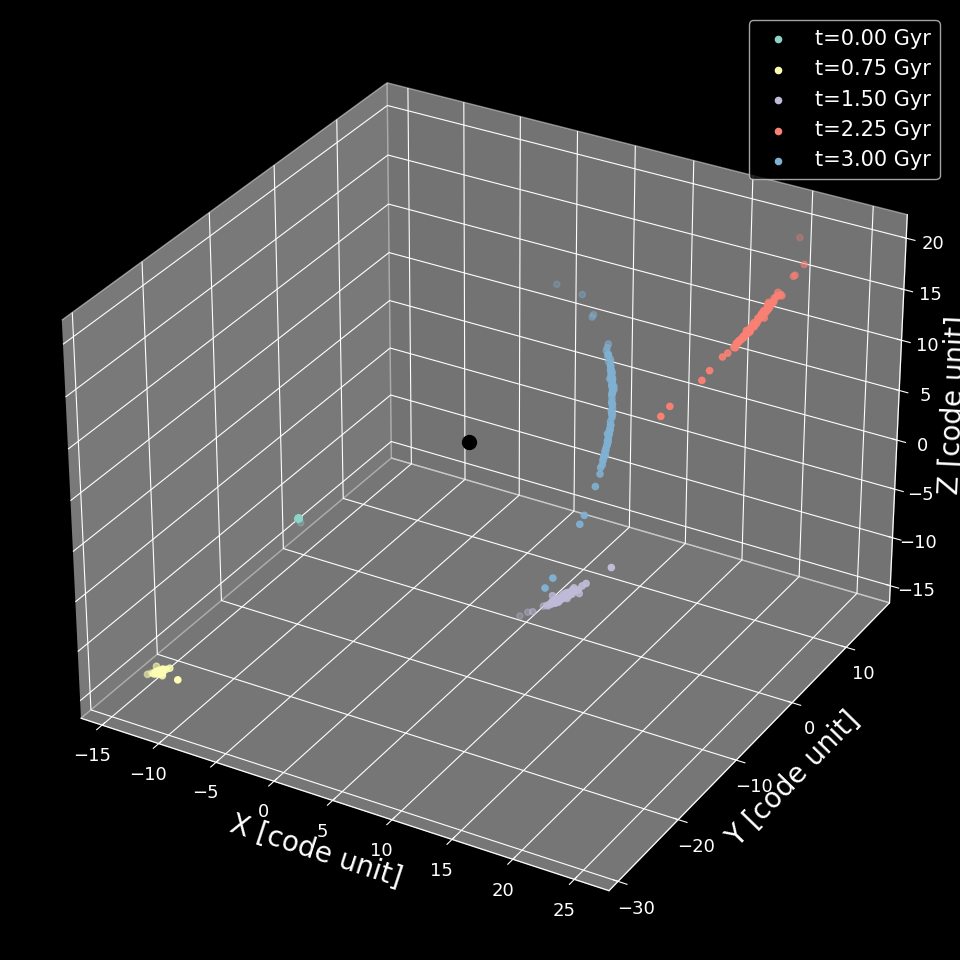

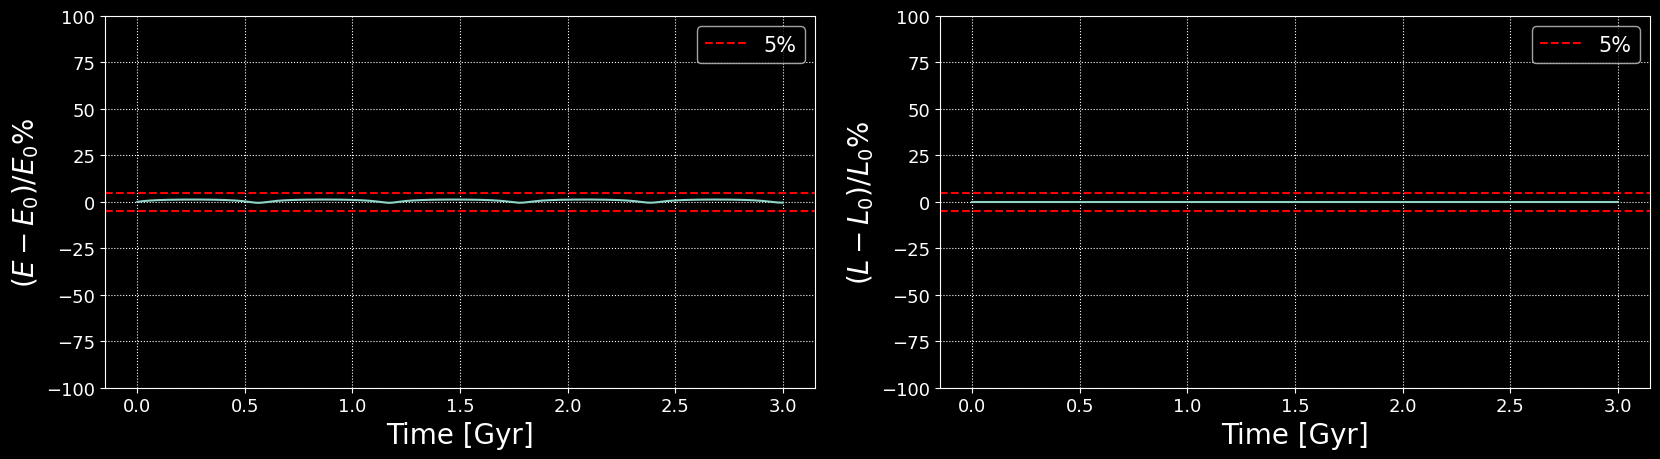

In [5]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


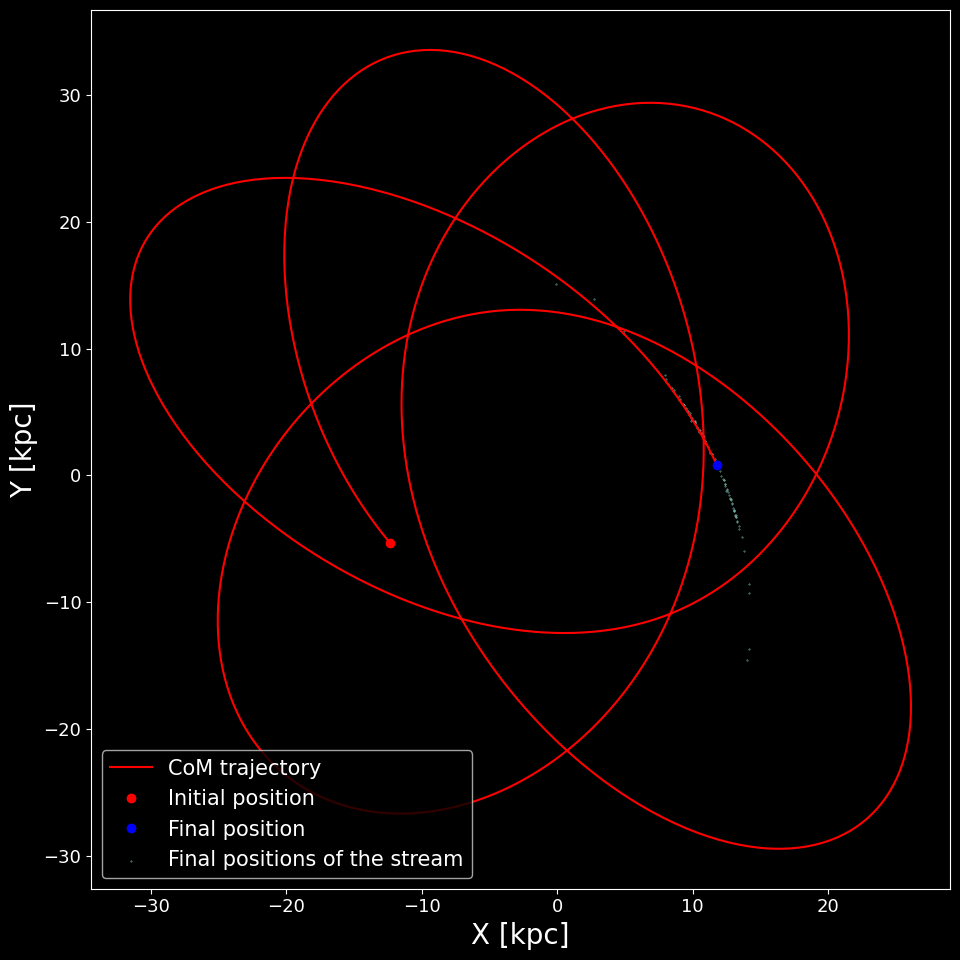

In [6]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()

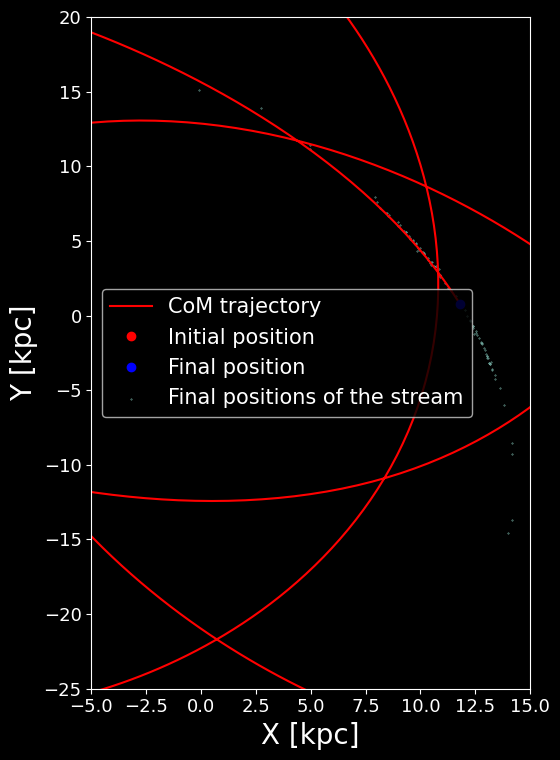

In [7]:
fig = plt.figure(figsize=(6, 8), tight_layout=True)
ax = fig.add_subplot(111)
conversion = code_units.code_length.to(u.kpc)
ax.plot(snapshots_com.states[:, 0, 0, 0]*conversion, 
        snapshots_com.states[:, 0, 0, 1]* conversion, 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]*conversion,
         snapshots_com.states[-1, 0, 0, 1]*conversion, 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]*conversion, 
        snapshots_com.states[0, 0, 0, 1]*conversion, 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]*conversion, 
           snapshots.states[-1, :, 0, 1]*conversion, s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-5, 15)
ax.set_ylim(-25, 20)
ax.legend()

In [8]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

(-250.0, 250.0)

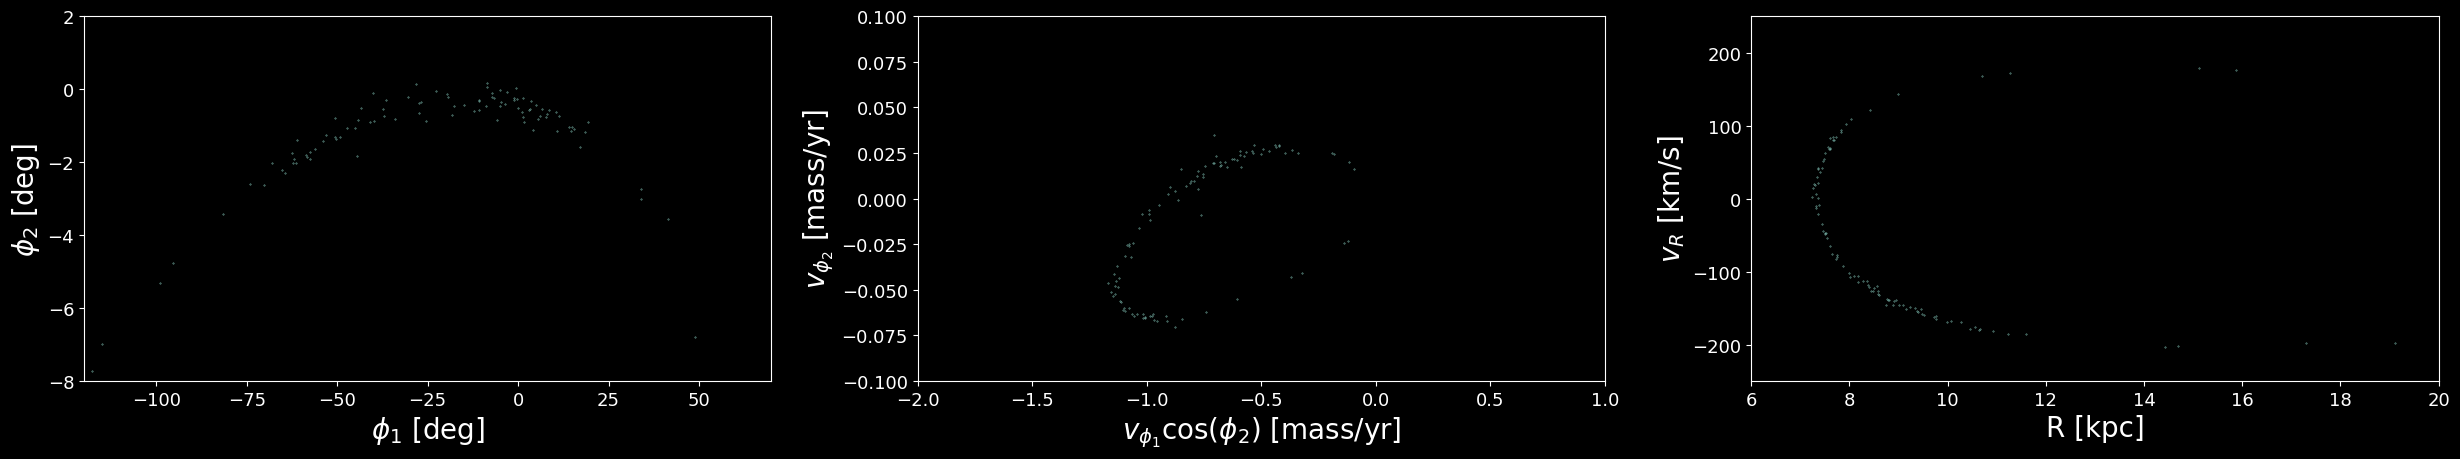

In [9]:
s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


/tmp/ipykernel_3289787/3570116978.py:21: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
/tmp/ipykernel_3289787/3570116978.py:31: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
/tmp/ipykernel_3289787/3570116978.py:40: RuntimeWarning: divide by zero encountered in log10
  im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')


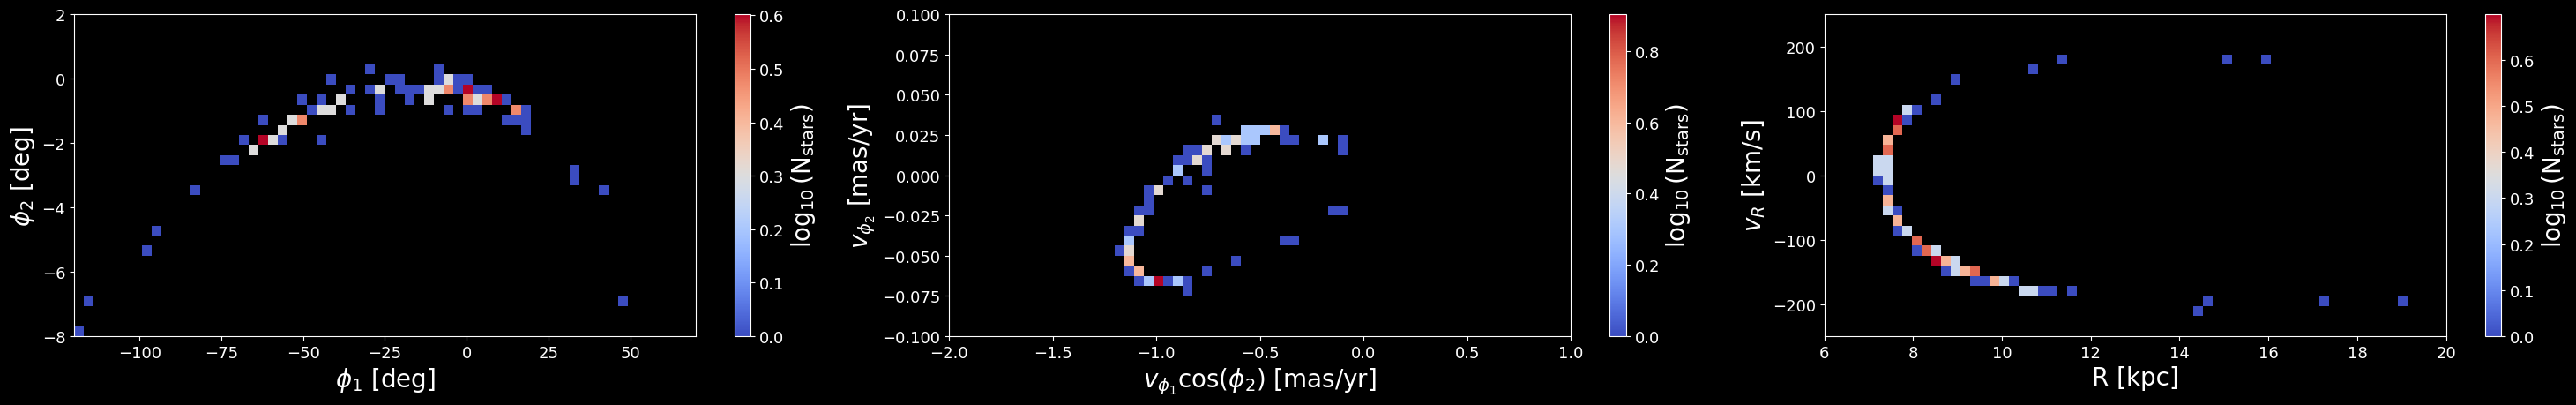

In [10]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30, 5), tight_layout=True)

# Define bin edges and create meshgrids
phi1_bins = jnp.linspace(-120, 70, 65)    # 64 bins
phi2_bins = jnp.linspace(-8, 2, 33)       # 32 bins
v1_bins = jnp.linspace(-2., 1.0, 65)      # 64 bins  
v2_bins = jnp.linspace(-0.10, 0.10, 33)   # 32 bins
R_bins = jnp.linspace(6, 20, 65)          # 64 bins
vR_bins = jnp.linspace(-250, 250, 33)     # 32 bins

# Create meshgrids for bin edges (not centers)
PHI1, PHI2 = jnp.meshgrid(phi1_bins, phi2_bins, indexing='ij')
V1, V2 = jnp.meshgrid(v1_bins, v2_bins, indexing='ij')
R_GRID, VR_GRID = jnp.meshgrid(R_bins, vR_bins, indexing='ij')

# Create 2D histograms
ax = fig.add_subplot(131)
counts1 = jnp.histogram2d(phi1, phi2, bins=[phi1_bins, phi2_bins])[0]
im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
# Define a normalization that centers white at 0
plt.colorbar(im1, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$',  )

ax = fig.add_subplot(132)
counts2 = jnp.histogram2d(v1_cosphi2, v2, bins=[v1_bins, v2_bins])[0]
im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

ax = fig.add_subplot(133)
counts3 = jnp.histogram2d(R, vR, bins=[R_bins, vR_bins])[0]
im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

(-8.0, 2.0)

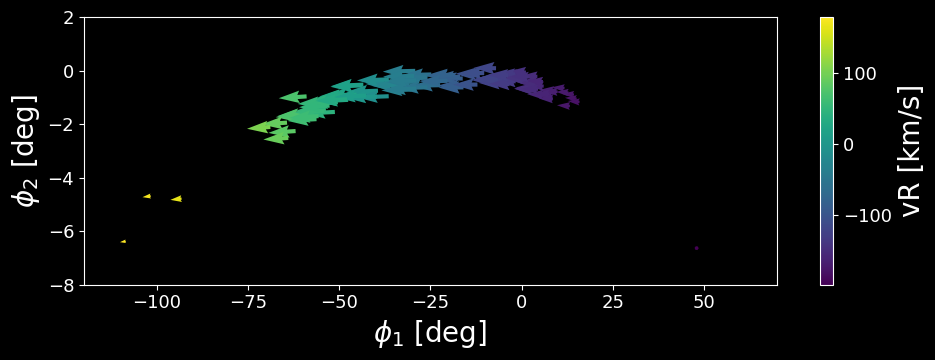

In [18]:
# Plotting the vector field of velocities
fig  = plt.figure(figsize=(10, 4), tight_layout=True)
ax = fig.add_subplot(111)
vectorf_field = ax.quiver(phi1, 
                            phi2,
                            v1_cosphi2/jnp.cos(jnp.deg2rad(phi2)),
                            v2,
                            vR,
                            scale=25,)
plt.colorbar(vectorf_field, ax=ax, label='vR [km/s]')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

In [19]:
stream_target = s

In [20]:
final_state_target = final_state.copy()
final_state_target = final_state_target.reshape(-1, 6)

In [21]:
stream_target.shape

(100, 6)

In [22]:
noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 1e-3])  #R, phi1, phi2, vR, v1, v2
jnp.expand_dims(noise_std, axis=0).repeat(stream_target.shape[0], axis=0)

Array([[2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.

# Parameters

# NFW Mass

In [ ]:
from jax.scipy.special import logsumexp

# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                         N_particles = 1000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                        #  integrator = DIFFRAX_BACKEND,
                        #  fixed_timestep = False,
                        #  diffrax_solver = TSIT5,
                         )

config_com = config_com._replace(return_snapshots=False,
                                #  integrator = DIFFRAX_BACKEND,
                                #  fixed_timestep = False,
                                #  diffrax_solver = TSIT5,
                                 )

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

# @jit
def time_integration_NFW_mass_grad(Mvir, key ):

    Mvir = 10**Mvir
    

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    print(stream.shape)

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 1e-3])

    
# 
    # kde = jax.scipy.stats.gaussian_kde(stream.T, )
   
    # return kde.pdf(stream_target.T).sum()
    
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)
    
    # return kde_loglik_diagonal(x_obs=stream_target, x_sim=stream, obs_err=jnp.expand_dims(noise_std, axis=0).repeat(stream_target.shape[0], axis=0), kernel_sigma=jnp.ones(6))
    # x_sim = stream  # (N,d)
    # x_obs = stream_target  # (M,d)
    # obs_err = jnp.expand_dims(noise_std, axis=0).repeat(stream_target.shape[0], axis=0)  # (M,d)

    # # 1) standardize
    # mean = jnp.mean(x_sim, axis=0)
    # std = jnp.std(x_sim, axis=0, ddof=1)
    # x_sim_std = (x_sim - mean) / std
    # x_obs_std = (x_obs - mean) / std
    # obs_err_std = obs_err / std

    # # 2) initial bandwidth (per-dim)
    # h0 = scott_bandwidth_per_dim(x_sim_std)

    # # 3) run kde lik
    # ll = kde_loglik_diagonal(x_obs_std, x_sim_std, obs_err_std, kernel_sigma=h0)
    # return ll

    # @jit 
    # def compute_mmd(sim_norm, target_norm, sigmas):
    #     xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
    #     yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
    #     xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
    #     return xx + yy - 2 * xy

    # distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(stream_target))(stream)
    # distance_flat = distances.flatten()

    # # # Use percentiles as natural scales
    # sigmas = jnp.array([
    #     jnp.percentile(distance_flat, 10),   # Fine scale
    #     jnp.percentile(distance_flat, 25),   # Small scale  
    #     jnp.percentile(distance_flat, 50),   # Medium scale (median)
    #     # jnp.percentile(distance_flat, 75),   # Large scale
    #     # jnp.percentile(distance_flat, 90),   # Very large scale
    # ])

    # # Adaptive weights based on scale separation
    # # scale_weights = jnp.array([0.15, 0.2, 0.3, 0.25, 0.1])
    # scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # # Compute MMD with multiple kernels
    # mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(stream, stream_target, sigma))(sigmas))
    
    # # return mmd_total / (len(sigmas) * 1000)
    # return jnp.log(mmd_total/len(sigmas))

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return -jnp.exp(-0.1*(xx + yy - 2 * xy))


    # Define bounds for normalization
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
    
    @jit
    def normalize_stream(stream):
        """Normalize each dimension to [0,1] using known bounds"""
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    @jit
    def robust_mmd_multiscale(stream1, stream2):
        """Robust multi-scale MMD with normalized inputs"""
        # Normalize both streams
        stream1_norm = normalize_stream(stream1)
        stream2_norm = normalize_stream(stream2)
        
        # Compute pairwise distances in normalized space
        def pairwise_distances(x, y):
            return jnp.linalg.norm(x[:, None, :] - y[None, :, :], axis=2)
        
        distances = pairwise_distances(stream1_norm, stream2_norm).flatten()
        
        # Use data-driven scales (percentiles of actual distances)
        sigmas = jnp.array([
            jnp.percentile(distances, 10),   # Fine details
            jnp.percentile(distances, 25),   # Local structure  
            jnp.percentile(distances, 50),   # Medium scale
            jnp.percentile(distances, 75),   # Large scale
        ])
        
        # Ensure minimum bandwidth for numerical stability
        sigmas = jnp.maximum(sigmas, 0.01)
        
        @jit
        def rbf_kernel(x, y, sigma):
            return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))
        
    #     @jit
    #     def mmd_single_scale(sigma):
    #         # Efficient MMD computation
    #         xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(stream1_norm))(stream1_norm))
    #         yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(stream2_norm))(stream2_norm))
    #         xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(stream2_norm))(stream1_norm))
    #         return xx + yy - 2 * xy
        
    #     # Compute MMD across scales
    #     mmd_values = jax.vmap(mmd_single_scale)(sigmas)
        
    #     # Weight scales (emphasize medium scales for stability)
    #     # weights = jnp.array([0.1, 0.3, 0.4, 0.2])
    #     weights = jnp.ones_like(sigmas)  
        
    #     return jnp.sum(weights * mmd_values)
    
    # mmd_loss = robust_mmd_multiscale(stream, stream_target)
    
    # # Return negative log of exponential (for minimization)
    return -mmd_loss 

    # def sinkhorn_divergence(X, Y, epsilon=0.1, n_iter=50):
    #     """
    #     Compute Sinkhorn divergence between two point clouds X and Y.
    #     Args:
    #         X: (N, d) jnp.array
    #         Y: (M, d) jnp.array
    #         epsilon: entropic regularization strength
    #         n_iter: number of Sinkhorn iterations
    #     Returns:
    #         scalar OT cost (differentiable)
    #     """
    #     N, M = X.shape[0], Y.shape[0]

    #     # cost matrix
    #     C = jnp.sum((X[:, None, :] - Y[None, :, :])**2, axis=-1)  # (N, M)

    #     # initialize dual variables in log domain
    #     f = jnp.zeros(N)  # log u
    #     g = jnp.zeros(M)  # log v

    #     def body_fn(_, state):
    #         f, g = state
    #         f = -logsumexp((-C + g[None, :] * epsilon) / epsilon, axis=1)
    #         g = -logsumexp((-C.T + f[None, :] * epsilon) / epsilon, axis=1)
    #         return (f, g)

    #     f, g = jax.lax.fori_loop(0, n_iter, body_fn, (f, g))

    #     # transport plan (in log domain)
    #     log_pi = (-C + f[:, None] * epsilon + g[None, :] * epsilon) / epsilon
    #     pi = jnp.exp(log_pi)

    #     # OT loss
    #     loss = jnp.sum(pi * C) / (N * M)
    #     return loss

    # return sinkhorn_divergence(stream, stream_target, epsilon=10, n_iter=20)


    # def _sinkhorn_ot_log_domain(C, epsilon, n_iter=100):
    #     """Compute entropic OT cost (not debiased) using log-domain Sinkhorn.
    #     C: (N, M) cost matrix
    #     returns: scalar OT cost (sum pi * C) / (N*M)
    #     """
    #     N, M = C.shape
    #     # log u = f, log v = g
    #     f = jnp.zeros(N)
    #     g = jnp.zeros(M)

    #     def body_fn(i, state):
    #         f, g = state
    #         # note: we keep expressions in log-domain carefully
    #         # (-C + g[None,:]*epsilon)/epsilon = -C/epsilon + g[None,:]
    #         f = -logsumexp((-C / epsilon) + g[None, :], axis=1)
    #         g = -logsumexp((-C.T / epsilon) + f[None, :], axis=1)
    #         return (f, g)

    #     f, g = jax.lax.fori_loop(0, n_iter, body_fn, (f, g))

    #     # log pi = (-C + f[:,None]*epsilon + g[None,:]*epsilon) / epsilon
    #     # simplify: log_pi = -C/epsilon + f[:,None] + g[None,:]
    #     log_pi = -C / epsilon + f[:, None] + g[None, :]
    #     pi = jnp.exp(log_pi)
    #     # OT cost normalized by total mass
    #     ot_cost = jnp.sum(pi * C) / (N * M)
    #     return ot_cost

    # def sinkhorn_debiased_multiscale(X, Y, epsilons=(0.5, 0.1, 0.02),
    #                                 n_iter=100, scale=1.0, normalize=True):
    #     """
    #     Debiased (Sinkhorn divergence) with multiple epsilons.
    #     Args:
    #         X: (N, d)
    #         Y: (M, d)
    #         epsilons: iterable of epsilon values (larger -> smoother)
    #         n_iter: sinkhorn iterations (log-domain)
    #         scale: divides the cost matrix by this factor (C <- C / scale)
    #         normalize: if True, divide each OT by typical scale (already done in _sinkhorn)
    #     Returns:
    #         scalar: sum_over_eps [ S_eps(X,Y) ]  (multi-scale debiased sinkhorn)
    #     """
    #     N = X.shape[0]
    #     M = Y.shape[0]

    #     # cost matrix (squared euclidean)
    #     C_xy = jnp.sum((X[:, None, :] - Y[None, :, :])**2, axis=-1) / scale
    #     C_xx = jnp.sum((X[:, None, :] - X[None, :, :])**2, axis=-1) / scale
    #     C_yy = jnp.sum((Y[:, None, :] - Y[None, :, :])**2, axis=-1) / scale

    #     def single_eps_loss(eps):
    #         ot_xy = _sinkhorn_ot_log_domain(C_xy, eps, n_iter=n_iter)
    #         ot_xx = _sinkhorn_ot_log_domain(C_xx, eps, n_iter=n_iter)
    #         ot_yy = _sinkhorn_ot_log_domain(C_yy, eps, n_iter=n_iter)
    #         debiased = ot_xy - 0.5 * (ot_xx + ot_yy)
    #         return debiased

    #     # sum (or weighted sum) across epsilons
    #     losses = jax.vmap(single_eps_loss)(jnp.array(epsilons))
    #     return jnp.sum(losses)

    # return sinkhorn_debiased_multiscale(stream, stream_target,
    #                                     epsilons=[0.5, 0.1, 0.02],
    #                                     n_iter=100,
    #                                     scale=1.0,
    #                                     normalize=True) / 1000

    # @jit
    # def kde_likelihood_smooth(model_stream, obs_stream, bandwidth_vector):
    #     """
    #     KDE likelihood with per-dimension bandwidths matching observational errors.
    #     """
    #     def single_obs_log_likelihood(obs_point):
    #         def kernel_contrib(model_point):
    #             scaled_diff = (obs_point - model_point) / bandwidth_vector
    #             log_kernel = -0.5 * jnp.sum(scaled_diff**2) - 0.5 * jnp.sum(jnp.log(2 * jnp.pi * bandwidth_vector**2))
    #             return log_kernel
            
    #         log_kernels = jax.vmap(kernel_contrib)(model_stream)
    #         return jax.scipy.special.logsumexp(log_kernels) - jnp.log(len(model_stream))
        
    #     log_likelihoods = jax.vmap(single_obs_log_likelihood)(obs_stream)
    #     return jnp.sum(log_likelihoods)

    # # Usage - replace your current likelihood:
    # noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.001])
    # return kde_likelihood_smooth(model_stream=stream,
    #                             obs_stream=stream_target, 
    #                             bandwidth_vector=noise_std) 

@jit
def log_diag_multivariate_normal(x, mean, cov):
    """
    Log PDF of a multivariate Gaussian with diagonal covariance.
    
    Parameters
    ----------
    x : (D,)
    mean : (D,)
    sigma : (D,)  # standard deviations
    """
    # diff = (x - mean) / sigma
    # D = x.shape[0]
    # log_det = 2.0 * jnp.sum(jnp.log(sigma))
    # norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
    # exponent = -0.5 * jnp.sum(diff**2)
    
    # return norm_const + exponent
    # return jax.scipy.stats.norm.logpdf(x, loc=mean, scale=sigma)
    return jax.scipy.stats.multivariate_normal.logpdf(x, mean=mean, cov=cov)


def stream_likelihood_diag(model_stream, obs_stream, obs_errors):
    """
    Log-likelihood of observed stars given simulated stream (diagonal covariance).
    
    Parameters
    ----------
    model_stream : (N_model, D)
    obs_stream   : (N_obs, D)
    obs_errors   : (D)  # per-observation standard deviations

    """
    print('observed stream shape:', obs_stream.shape)
    print('model stream shape:', model_stream.shape)
    # Observational covariance (diagonal)
    obs_cov = jnp.diag(obs_errors**2)
    
    # Model covariance from simulation scatter
    model_cov = jnp.cov(model_stream, rowvar=False)
    
    # Total covariance for each point
    total_cov = obs_cov + model_cov

    print(total_cov.shape)

    def log_single_point_sim(sim_point):
        return log_diag_multivariate_normal(obs_stream, mean=sim_point, cov=total_cov)

    # return jax.scipy.special.logsumexp(jax.vmap(log_single_point_sim)(model_stream)) - jnp.log(len(model_stream))
    return jnp.mean(jax.vmap(log_single_point_sim)(model_stream))

# def log_diag_multivariate_normal(x, mean, sigma):
#         """
#         Log PDF of a multivariate Gaussian with diagonal covariance.
        
#         Parameters
#         ----------
#         x : (D,)
#         mean : (D,)
#         sigma : (D,)  # standard deviations for each dimension
#         """
#         diff = (x - mean) / sigma
#         D = x.shape[0]
#         log_det = 2.0 * jnp.sum(jnp.log(sigma))
#         norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
#         exponent = -0.5 * jnp.sum(diff**2)
#         return norm_const + exponent

# def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
#     """
#     Log-likelihood of observed stars given simulated stream (diagonal covariance).
    
#     Parameters
#     ----------
#     model_stream : (N_model, D)
#     obs_stream : (N_obs, D)
#     obs_errors : (N_obs, D)   # per-dimension standard deviations
#     tau : float
#         Stream membership fraction
#     p_field : float
#         Background probability density
#     """
#     def obs_log_prob(obs, sigma):
#         def model_log_prob(model_point):
#             return log_diag_multivariate_normal(obs, model_point, sigma)

#         # Compute log_probs for all model points
#         log_probs = jax.vmap(model_log_prob)(model_stream)
        
#         # Numerically stable average: log(mean(exp(log_probs)))
#         # log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
#         log_p_stream = jnp.sum(log_probs) - jnp.log(model_stream.shape[0])
        
#         # Mixture model
#         # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
#         # p_total = jnp.exp(log_p_stream)
#         # return jnp.log(p_total + 1e-30)
#         return log_p_stream

#     # Vectorize over observations
#     obs_error = jnp.asarray(obs_errors).reshape((1, 6))  # (1,D)
#     obs_error = jnp.repeat(obs_error, obs_stream.shape[0], axis=0)  # (N_obs,D)
#     print(obs_error[0])
#     logL_values = jax.vmap(obs_log_prob)(obs_stream, obs_error)
#     return jnp.sum(logL_values)/1_000


def scott_bandwidth_per_dim(x_model):
    # x_model: (N, d)
    N, d = x_model.shape
    std = jnp.std(x_model, axis=0, ddof=1)
    h = std * (N ** (-1.0 / (d + 4.0)))
    return h

def kde_loglik_diagonal(x_obs, x_sim, obs_err, kernel_sigma):
    """
    x_obs: (M, d)
    x_sim: (N, d)
    obs_err: (M, d)  -- per-observation 1-sigma errors per-dimension
    kernel_sigma: (d,) or scalar  -- 1-sigma kernel width per-dimension
    returns: scalar log-likelihood
    """
    M, d = x_obs.shape
    N = x_sim.shape[0]
    # ensure shapes
    kernel_sigma = jnp.asarray(kernel_sigma).reshape((1, d))  # (1,d)
    # squared diff (M, N, d)
    diff = x_obs[:, None, :] - x_sim[None, :, :]  # broadcast
    sq = diff**2  # (M,N,d)

    # per-dim variances: s_{i,j,p} = k_p^2 + e_{i,p}^2
    var_obs = (obs_err**2)[:, None, :]            # (M,1,d)
    var_kernel = (kernel_sigma**2)[None, None, :] # (1,1,d)
    S = var_kernel + var_obs                      # (M,N,d)

    # log-det term (sum log of diagonal entries)
    logdet = jnp.sum(jnp.log(S), axis=-1)         # (M,N)

    # Mahalanobis term: sum over p of sq / S
    maha = jnp.sum(sq / S, axis=-1)               # (M,N)

    const = -0.5 * d * jnp.log(2 * jnp.pi)

    # log kernel per (i,j)
    log_kernel = const - 0.5 * logdet - 0.5 * maha  # (M,N)

    # mix over simulated points (uniform weights 1/N)
    log_probs = logsumexp(log_kernel, axis=1) - jnp.log(N)  # (M,)

    return jnp.sum(log_probs)
        
    

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = params.NFW_params.Mvir*(3/4)
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
# test = check_grads(time_integration_NFW_mass_grad, jnp.array([Mvir]), order=3)
# loss = time_integration_NFW_mass_grad(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

(1000, 6)
observed stream shape: (100, 6)
model stream shape: (1000, 6)
(6, 6)
Gradient of the total mass of the Mvir of NFW:
 nan
Loss:
 nan


: 

In [ ]:
n_sim = 99
keys = jnp.arange(n_sim+1)
Mvir = np.linspace(params.NFW_params.Mvir*(0.50), params.NFW_params.Mvir*(2.), n_sim) 
# Correct way to append - assign the result back to Mvir
Mvir = np.concatenate([Mvir, np.array([params.NFW_params.Mvir])]) # Append the true Mvir value
Mvir = jnp.array(np.sort(Mvir))

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

Mvir_sharded = jnp.log10(Mvir_sharded)

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_mass_grad_map(Mvir_and_key_NF):
    Mvir, key, = Mvir_and_key_NF
    return jax.value_and_grad(time_integration_NFW_mass_grad)(Mvir, key, )

loss, grad = jax.lax.map(
    time_integration_NFW_mass_grad_map, 
    (Mvir_sharded, keys_sharded), 
    batch_size=12
)

plt.figure()
plt.plot(Mvir*(code_units.code_mass).to(u.Msun), loss)
plt.plot(Mvir[jnp.argmax(loss)]*(code_units.code_mass).to(u.Msun), loss[jnp.argmax(loss)], 'ro', label='Max Loss')
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend() 
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass.pdf')

(1000, 6)
observed stream shape: (100, 6)
model stream shape: (1000, 6)
(6, 6)


(array([ 2., 12., 34., 34., 17.,  0.,  0.,  0.,  0.,  1.]),
 array([-4.62812039e+15, -2.43348498e+15, -2.38849305e+14,  1.95578637e+15,
         4.15042178e+15,  6.34505719e+15,  8.53969314e+15,  1.07343280e+16,
         1.29289640e+16,  1.51235988e+16,  1.73182359e+16]),
 <BarContainer object of 10 artists>)

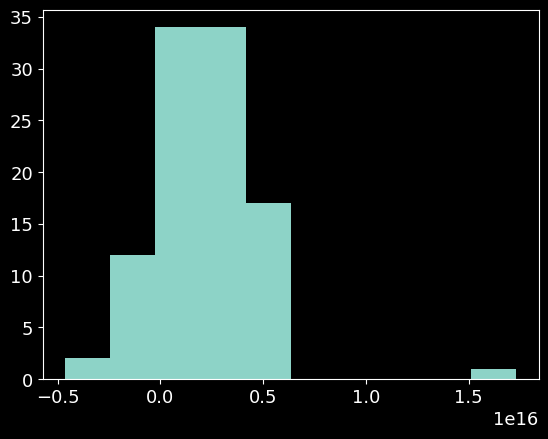

In [ ]:
plt.hist(grad)

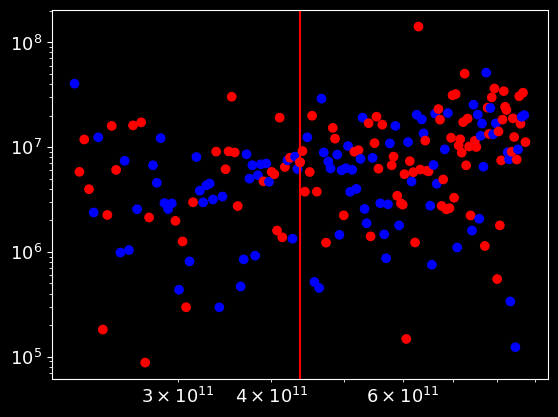

In [25]:
plt.scatter(Mvir*(code_units.code_mass).to(u.Msun), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

## NFW_r_s

In [ ]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                          integrator = DIFFRAX_BACKEND,
                         fixed_timestep = False,
                         diffrax_solver = TSIT5,)
config_com = config_com._replace(return_snapshots=False,
                                  integrator = DIFFRAX_BACKEND,
                                  fixed_timestep = False,
                                  diffrax_solver = TSIT5,)

@jit
def time_integration_NFW_r_s_grad(r_s, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    r_s=r_s 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    r_s=r_s 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.mean(logL_values)/1_000
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
r_s = params.NFW_params.r_s*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_r_s_grad, )(r_s, key)
print("Gradient of the total mass of the r_s of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the r_s of NFW:
 -0.22601509
Loss:
 -0.049773384


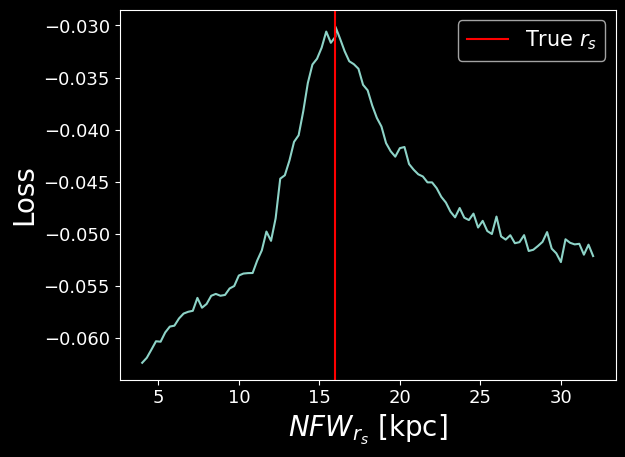

In [32]:
n_sim = 99
keys = jnp.arange(n_sim+1)
r_s = np.linspace(params.NFW_params.r_s*(1/4), params.NFW_params.r_s*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
r_s = np.concatenate([r_s, np.array([params.NFW_params.r_s])]) # Append the true Mvir value
r_s = jnp.array(np.sort(r_s))

mesh = Mesh(np.array(jax.devices()), ("i",))
r_s_sharded = jax.device_put(r_s, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_r_s_grad_map(r_s_and_key):
    r_s, key = r_s_and_key
    return jax.value_and_grad(time_integration_NFW_r_s_grad)(r_s, key)

loss, grad = jax.lax.map(
    time_integration_NFW_r_s_grad_map, 
    (r_s_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(r_s_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.NFW_params.r_s*(code_units.code_length).to(u.kpc), color='r', label='True $r_{s}$')
plt.xlabel("$NFW_{r_s}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_NFW_rs.pdf')

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  2., 87.,  8.,  1.]),
 array([-245.17704773, -213.49264526, -181.80822754, -150.12382507,
        -118.43942261,  -86.75502014,  -55.07060242,  -23.38619995,
           8.29820251,   39.98262024,   71.66701508]),
 <BarContainer object of 10 artists>)

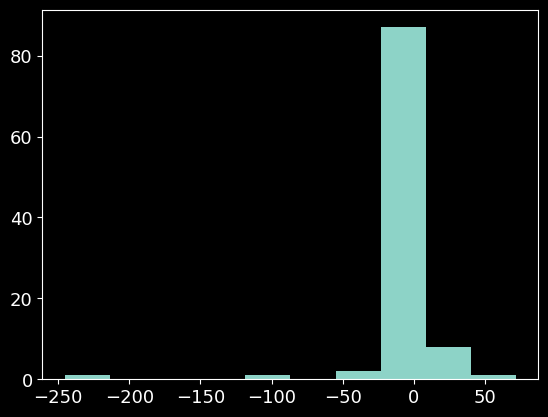

In [33]:
plt.hist(grad)

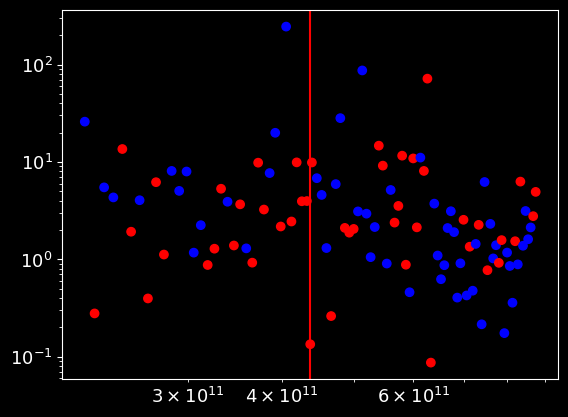

In [35]:
plt.scatter(Mvir*(code_units.code_mass).to(u.Msun), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

# Miamoto Nagai Parameters

# Mass of MN

In [44]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_M_grad(M, key):

    M = 10**M

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    M=M 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    M=M 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.mean(logL_values)/1_000
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
M = params.MN_params.M*(3/4) 
M = jnp.log10(M)
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_M_grad, )(M, key)
print("Gradient of the total mass of the M of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the M of MN:
 -7.5396147
Loss:
 -0.04029474


/tmp/ipykernel_3881007/619647188.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


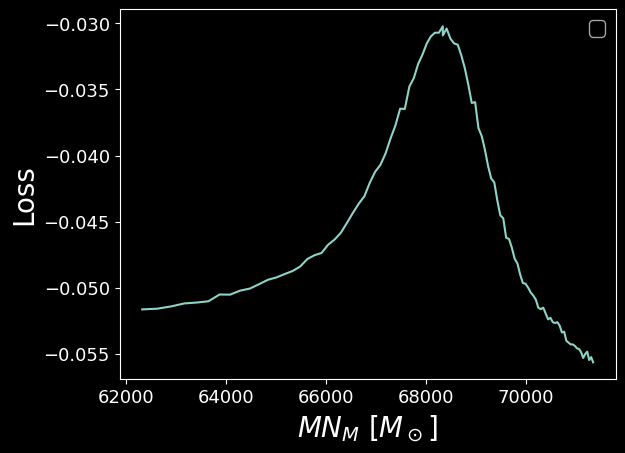

In [49]:
n_sim = 99
keys = jnp.arange(n_sim+1)
M = np.linspace(params.MN_params.M*(1/4), params.MN_params.M*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
M = np.concatenate([M, np.array([params.MN_params.M])]) # Append the true Mvir value
M = jnp.array(np.sort(M))


mesh = Mesh(np.array(jax.devices()), ("i",))
M_sharded = jax.device_put(M, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
M_sharded = jnp.log10(M_sharded)

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_M_grad_map(M_and_key):
    M, key = M_and_key
    return jax.value_and_grad(time_integration_MN_M_grad)(M, key)

loss, grad = jax.lax.map(
    time_integration_MN_M_grad_map, 
    (M_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(M_sharded*(code_units.code_mass).to(u.Msun), loss)
# plt.axvline(params.MN_params.M*(code_units.code_mass).to(u.Msun), color='r', label='True $MN_{M}$')
plt.xlabel("$MN_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_MN_mass.pdf')

(array([ 5.,  8., 13., 49., 14.,  4.,  1.,  4.,  1.,  1.]),
 array([-54.207901  , -39.55891418, -24.90993118, -10.26094818,
          4.38803864,  19.03702545,  33.68600464,  48.33499146,
         62.98397827,  77.63296509,  92.2819519 ]),
 <BarContainer object of 10 artists>)

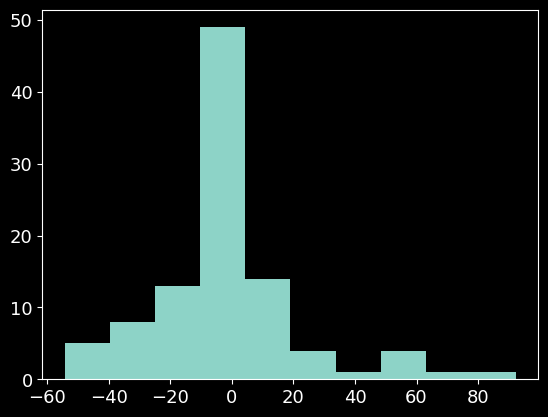

In [51]:
plt.hist(grad)

# a of MN

In [52]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_a_grad(a, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    a=a 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    a=a 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.mean(logL_values)/1_000
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
a = params.MN_params.a*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_a_grad, )(a, key)
print("Gradient of the total mass of the a of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the a of MN:
 0.2600882
Loss:
 -0.030842813


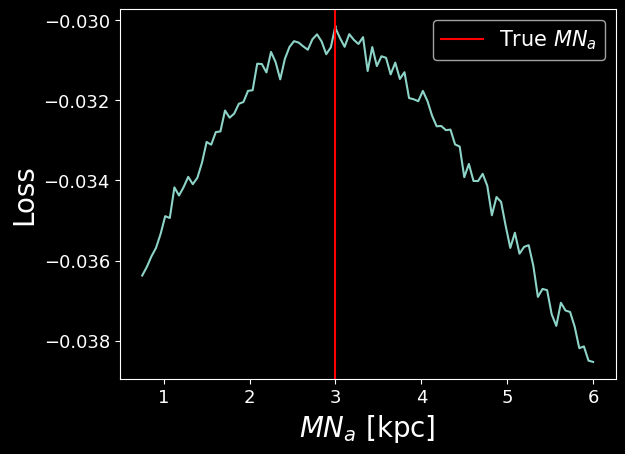

In [53]:
n_sim = 99
keys = jnp.arange(n_sim+1)
a = np.linspace(params.MN_params.a*(1/4), params.MN_params.a*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
a = np.concatenate([a, np.array([params.MN_params.a])]) # Append the true Mvir value
a = jnp.array(np.sort(a))

mesh = Mesh(np.array(jax.devices()), ("i",))
a_sharded = jax.device_put(a, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_a_grad_map(a_and_key):
    a, key = a_and_key
    return jax.value_and_grad(time_integration_MN_a_grad)(a, key)

loss, grad = jax.lax.map(
    time_integration_MN_a_grad_map, 
    (a_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(a_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.MN_params.a*(code_units.code_length).to(u.kpc), color='r', label='True $MN_{a}$')
plt.xlabel("$MN_{a}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_MN_a.pdf')

(array([ 5.,  2.,  5., 11., 32., 26.,  8.,  4.,  6.,  1.]),
 array([-11.2229948 ,  -8.93947792,  -6.65596199,  -4.37244558,
         -2.08892918,   0.19458675,   2.47810364,   4.76162052,
          7.04513645,   9.32865238,  11.61216927]),
 <BarContainer object of 10 artists>)

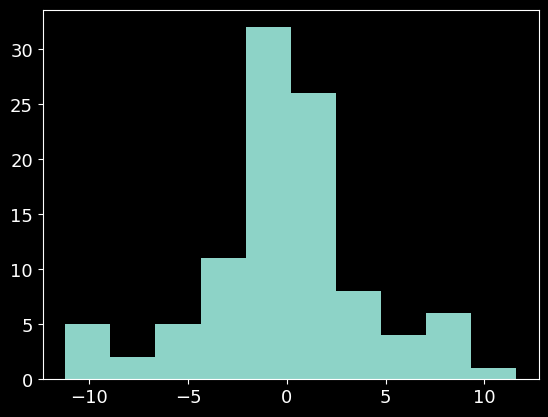

In [54]:
plt.hist(grad)

# b of MN

In [22]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_b_grad(b, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    b=b 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    b=b 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
b = params.MN_params.b*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_a_grad, )(b, key)
print("Gradient of the total mass of the a of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the a of MN:
 204783.84
Loss:
 -3827.6367


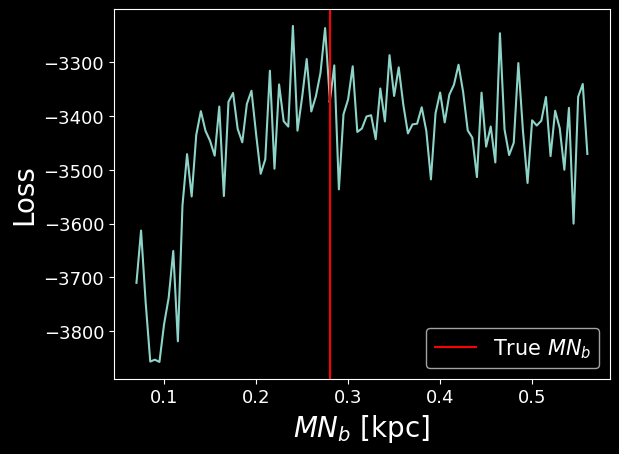

In [23]:
n_sim = 99
keys = jnp.arange(n_sim+1)
b = np.linspace(params.MN_params.b*(1/4), params.MN_params.b*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
b = np.concatenate([b, np.array([params.MN_params.b])]) # Append the true Mvir value
b = jnp.array(np.sort(b))

mesh = Mesh(np.array(jax.devices()), ("i",))
b_sharded = jax.device_put(b, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_b_grad_map(b_and_key):
    b, key = b_and_key
    return jax.value_and_grad(time_integration_MN_b_grad)(b, key)

loss, grad = jax.lax.map(
    time_integration_MN_b_grad_map, 
    (b_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(b_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.MN_params.b*(code_units.code_length).to(u.kpc), color='r', label='True $MN_{b}$')
plt.xlabel("$MN_{b}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_landscape/loss_landscape_MN_b.pdf')

# PSP parameters

# M of PSP

In [24]:
config_com = config_com._replace(return_snapshots=False,)
config = config._replace(return_snapshots=False,)

@jit
def time_integration_PSP_M_grad(M, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    M=M 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    M=M 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot])
    #we construmt the initial state of the com  
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]
    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)
    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,) 
    #we calculate the loss as the negative log likelihood of the stream
    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
M = params.PSP_params.M*(3/4)
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_M_grad, )(M, key)
print("Gradient of the total mass of the M of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the M of PSP:
 0.1310621
Loss:
 -3467.3672


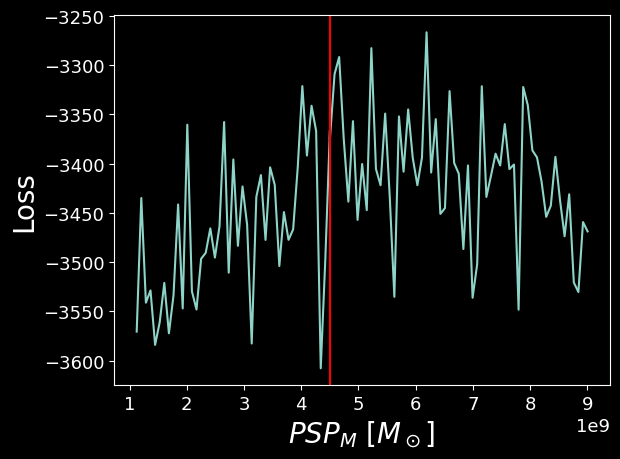

In [25]:
n_sim = 99
keys = jnp.arange(n_sim+1)
M = np.linspace(params.PSP_params.M*(1/4), params.PSP_params.M*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
M = np.concatenate([M, np.array([params.PSP_params.M])])  # Append the true Mvir value
M = jnp.array(np.sort(M))
mesh = Mesh(np.array(jax.devices()), ("i",))
M_sharded = jax.device_put(M, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_M_grad_map(M_and_key):
    M, key = M_and_key
    return jax.value_and_grad(time_integration_PSP_M_grad)(M, key)
loss, grad = jax.lax.map(
    time_integration_PSP_M_grad_map, 
    (M_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(M_sharded*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.PSP_params.M*(code_units.code_mass).to(u.Msun), color='r', label='True $PSP_{M}$')
plt.xlabel("$PSP_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.savefig('./loss_landscape/loss_landscape_PSP_mass.pdf')

# alpha of PSP

In [26]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_PSP_alpha_grad(alpha, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    alpha=alpha 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    alpha=alpha 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
alpha = 2.9
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_alpha_grad, )(alpha, key)
print("Gradient of the total mass of the alpha of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the alpha of PSP:
 -78934.36
Loss:
 -3577.2239


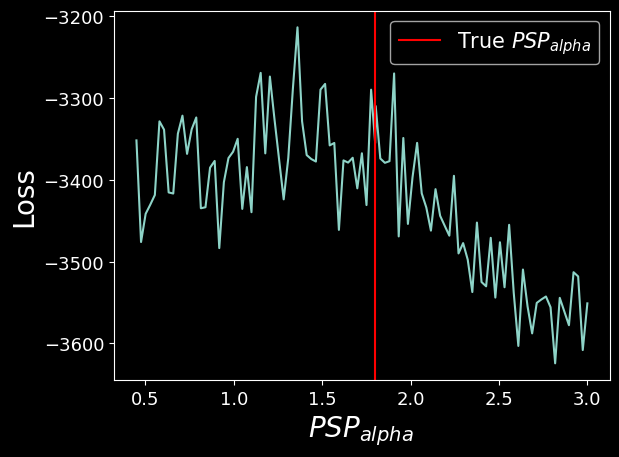

In [27]:
n_sim = 99
keys = jnp.arange(n_sim+1)
alpha = np.linspace(params.PSP_params.alpha*(1/4), 3, n_sim)
# Correct way to append - assign the result back to Mvir
alpha = np.concatenate([alpha, np.array([params.PSP_params.alpha])])  # Append the true Mvir value
alpha = jnp.array(np.sort(alpha))
mesh = Mesh(np.array(jax.devices()), ("i",))
alpha_sharded = jax.device_put(alpha, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_alpha_grad_map(alpha_and_key):
    alpha, key = alpha_and_key
    return jax.value_and_grad(time_integration_PSP_alpha_grad)(alpha, key)
loss, grad = jax.lax.map(
    time_integration_PSP_alpha_grad_map, 
    (alpha_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(alpha_sharded, loss)
plt.axvline(params.PSP_params.alpha, color='r', label='True $PSP_{alpha}$')
plt.xlabel("$PSP_{alpha}$ ")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_PSP_alpha.pdf')

# r_c of PSP

In [28]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit

def time_integration_PSP_r_c_grad(r_c, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    r_c=r_c 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    r_c=r_c 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)

# Calculate the value of the function and the gradient wrt the r_c of the PSP
r_c = params.PSP_params.r_c*(3/4)
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_r_c_grad, )(r_c, key)
print("Gradient of the total mass of the r_c of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the r_c of PSP:
 2.838761e-31
Loss:
 -3356.3735


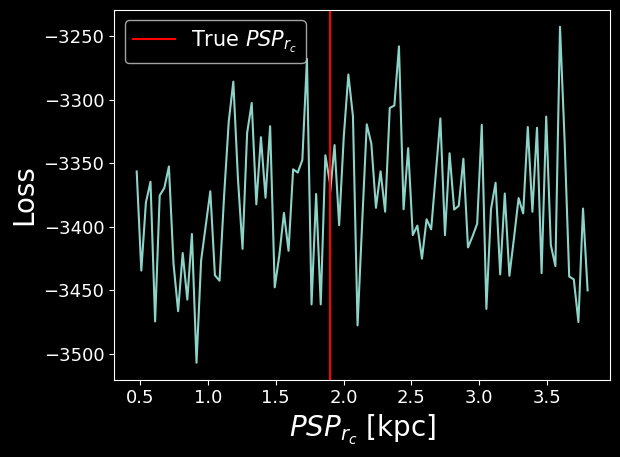

In [29]:
n_sim = 99
keys = jnp.arange(n_sim+1)
r_c = np.linspace(params.PSP_params.r_c*(1/4), params.PSP_params.r_c*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
r_c = np.concatenate([r_c, np.array([params.PSP_params.r_c])])  # Append the true Mvir value
r_c = jnp.array(np.sort(r_c))
mesh = Mesh(np.array(jax.devices()), ("i",))
r_c_sharded = jax.device_put(r_c, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_r_c_grad_map(r_c_and_key):
    r_c, key = r_c_and_key
    return jax.value_and_grad(time_integration_PSP_r_c_grad)(r_c, key)
loss, grad = jax.lax.map(
    time_integration_PSP_r_c_grad_map, 
    (r_c_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(r_c_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.PSP_params.r_c*(code_units.code_length).to(u.kpc), color='r', label='True $PSP_{r_c}$')
plt.xlabel("$PSP_{r_c}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_PSP_rc.pdf')

# Combined parameters

## t_end and t_end_vs_NFW_mass

Gradient of the total mass of the t_end:
 0.08564987
Loss:
 -0.030635234


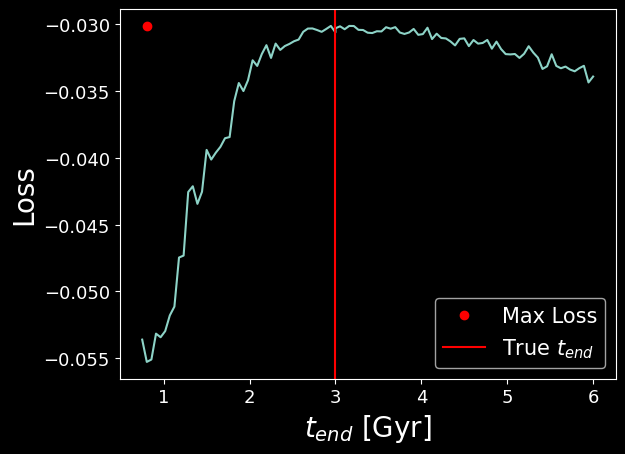

In [14]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 1_000, )
# config_com = config_com._replace(return_snapshots=False,)
config =  config._replace(return_snapshots=False,
                         N_particles = 1000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                         integrator = DIFFRAX_BACKEND,
                         fixed_timestep = False,
                         )

config_com = config_com._replace(return_snapshots=False,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                #  integrator = LEAPFROG,
                                 )
stream_target = s
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit
def time_integration_tend_grad(t_end, key):
    t_end = jnp.log10(t_end)

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params_com = params_com._replace(t_end = -t_end,)
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
    

    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """

        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        # logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        logL_values = jax.vmap(obs_log_prob,)(
                obs_stream, obs_errors.reshape(-1, 6)
            )
        # logL_values = jax.vmap(obs_log_prob, in_axes=(0, None))(
        #         obs_stream, obs_errors
        #     )

        return jnp.mean(logL_values)/1_000
    
    # return stream_likelihood_diag(model_stream=stream,
    #                          obs_stream=stream_target,
    #                          obs_errors=noise_std.repeat(stream.shape[0]))

    @jit 
    def compute_mmd(sim_norm, target_norm, sigmas):
        xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
        yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
        xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
        return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(stream_target))(stream)
    distance_flat = distances.flatten()

    # # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        # jnp.percentile(distance_flat, 75),   # Large scale
        # jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    # scale_weights = jnp.array([0.15, 0.2, 0.3, 0.25, 0.1])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(stream, stream_target, sigma))(sigmas))
    
    # return mmd_total / (len(sigmas) * 1000)
    return jnp.log(mmd_total/len(sigmas))



# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = 10**params.t_end*(0.90)
key = 0
loss, grad = jax.value_and_grad(time_integration_tend_grad, )(t_end, key)
print("Gradient of the total mass of the t_end:\n", grad)
print("Loss:\n", loss)  
n_sim = 99
keys = jnp.arange(n_sim+1)
t_end = np.linspace(params.t_end*(1/4), params.t_end*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
t_end = np.concatenate([t_end, np.array([params.t_end])]) # Append the true Mvir value
t_end = jnp.array(np.sort(t_end))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

mesh = Mesh(np.array(jax.devices()), ("i",))
t_end_sharded = jax.device_put(t_end, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

t_end_sharded =  10**t_end_sharded

@jit
def time_integration_NFW_tend_map(t_end_and_key):
    t_end, key = t_end_and_key
    return jax.value_and_grad(time_integration_tend_grad)(t_end, key)

loss, grad = jax.lax.map(
    time_integration_NFW_tend_map, 
    (t_end_sharded, keys_sharded), 
    batch_size=3,
)

plt.figure()
plt.plot(t_end*(code_units.code_time).to(u.Gyr), loss)
plt.plot(t_end[jnp.argmin(loss)]*(code_units.code_time).to(u.Gyr), loss[jnp.argmax(loss)], 'ro', label='Max Loss')
plt.axvline(params.t_end*(code_units.code_time).to(u.Gyr), color='r', label='True $t_{end}$')
plt.xlabel("$t_{end}$ [Gyr]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_t_end.pdf')


(array([ 1.,  0.,  1.,  8., 43., 27., 13.,  4.,  2.,  1.]),
 array([-18.24023819, -14.54080486, -10.84137154,  -7.14193916,
         -3.44250584,   0.25692749,   3.95635986,   7.65579414,
         11.35522652,  15.0546608 ,  18.75409508]),
 <BarContainer object of 10 artists>)

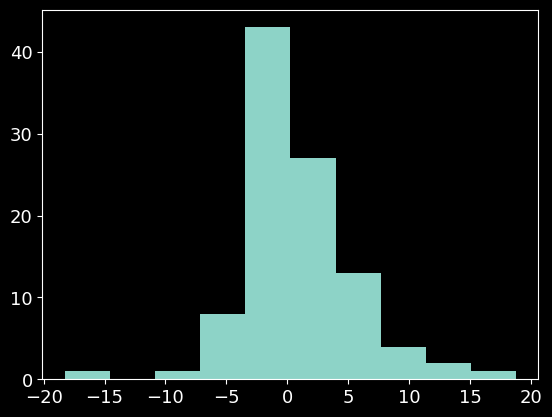

In [47]:
plt.hist(grad)

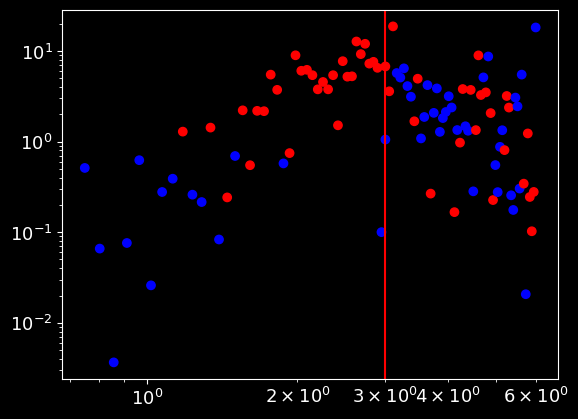

In [48]:
plt.scatter(t_end*(code_units.code_time).to(u.Gyr), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.t_end*(code_units.code_time).to(u.Gyr), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

In [14]:
# Gradient on the loss for 2 parameters
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 500, )
# config_com = config_com._replace(return_snapshots=False,)

# config =  config._replace(return_snapshots=False,)
# config_com = config_com._replace(return_snapshots=False,)
from odisseo.option_classes import LEAPFROGMIDPOINT, REVERSIBLEHEUN
config =  config._replace(return_snapshots=False,
                         N_particles = 1000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                         integrator = DIFFRAX_BACKEND,
                         diffrax_solver = TSIT5,
                         )

config_com = config_com._replace(return_snapshots=False,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )
stream_target = s
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_NFWmass_tend_grad(Mvir, t_end, key):

    # t_end = jnp.log10(t_end)
    Mvir = 10**Mvir

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params = new_params._replace(
                t_end=t_end,  # Update the t_end parameter
                )
    
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    
    #we also update the t_end parameter for the center of mass
    new_params_com = new_params_com._replace(
                t_end=-t_end,  # Update the t_end parameter for the center of mass
                )
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    # def compute_log_likelihood_cov(stream_target: jnp.ndarray,
    #                            stream: jnp.ndarray,
    #                            bandwidth: float):

    #     N, D = stream_target.shape
    #     K = stream.shape[0]

    #     # Empirical covariance from stream, scaled by h^2
    #     base_cov = jnp.cov(stream, rowvar=False)
    #     model_cov = (bandwidth ** 2) * base_cov

    #     # Observational uncertainty: diagonal covariance matrix
    #     noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 1e-3])  # shape (6,)
    #     obs_cov = jnp.diag(noise_std ** 2)  # shape (6, 6)

    #     # Total covariance: model smoothing + observational uncertainty
    #     cov = model_cov + obs_cov
    #     # cov = obs_cov
    #     inv_cov = jnp.linalg.inv(cov)
    #     log_det_cov = jnp.linalg.slogdet(cov)[1]

    #     def log_likelihood_single(Xn):
    #         diffs = Xn - stream  # shape (K, D)
    #         exponents = -0.5 * jnp.einsum("ki,ij,kj->k", diffs, inv_cov, diffs)  # shape (K,)
    #         normalizer = -0.5 * D * jnp.log(2 * jnp.pi) - 0.5 * log_det_cov
    #         log_probs = normalizer + exponents

    #         # Log-sum-exp trick
    #         max_logp = jnp.max(log_probs)
    #         log_pXn = max_logp + jnp.log(jnp.sum(jnp.exp(log_probs - max_logp))) - jnp.log(K)
    #         return log_pXn

    #     log_likelihoods = jax.vmap(log_likelihood_single)(stream_target)
    #     return jnp.sum(log_likelihoods)

    # def marginal_log_likelihood_over_bandwidths(stream_target: jnp.ndarray,
    #                                         stream: jnp.ndarray,
    #                                         h_grid: jnp.ndarray,
    #                                         prior_weights: jnp.ndarray) -> float:
    #     """
    #     Marginalize the log-likelihood over a grid of bandwidth values h.

    #     Parameters:
    #     -----------
    #     target_stream : jnp.ndarray, shape (N, 6)
    #         Observed stream.
    #     stream : jnp.ndarray, shape (K, 6)
    #         Simulated model stream.
    #     h_grid : jnp.ndarray, shape (M,)
    #         Bandwidth values over which to marginalize.
    #     prior_weights : jnp.ndarray, shape (M,)
    #         Weights for each bandwidth, including the prior and grid spacing.

    #     Returns:
    #     --------
    #     log_likelihood : float
    #         Log marginal likelihood after integrating over h.
    #     """
    #     N = stream_target.shape[0]

    #     def log_p_Xn_marginal(Xn):
    #         # Evaluate p(Xn | theta) = sum_i w_i * p(Xn | h_i, theta)
    #         def p_Xn_given_hi(h_i):
    #             return jnp.exp(compute_log_likelihood_cov(Xn[None, :], stream, h_i))  # scalar

    #         # Vectorize over h_i
    #         p_vals = jax.vmap(p_Xn_given_hi)(h_grid)  # shape (M,)
    #         weighted_sum = jnp.sum(prior_weights * p_vals)
    #         return jnp.log(weighted_sum + 1e-30)  # add small term for numerical safety

    #     # Sum log-likelihoods for all data points
    #     log_probs = jax.vmap(log_p_Xn_marginal)(stream_target)
    #     return jnp.sum(log_probs)
    
    # h_grid = jnp.logspace(-1.0, 1.0, num=1500)  # h from 0.01 to 1.0
    # log_prior = -jnp.log(h_grid)              # log-uniform: p(h) ∝ 1/h
    # prior_weights = jnp.exp(log_prior)
    # prior_weights = prior_weights / jnp.sum(prior_weights)  # normalize

    # return marginal_log_likelihood_over_bandwidths(stream_target, stream, h_grid, prior_weights)
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.00001])
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        # logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        logL_values = jax.vmap(obs_log_prob, in_axes=(0, None))(
                obs_stream, obs_errors
            )
        return jnp.sum(logL_values)
    
    # return stream_likelihood_diag(model_stream=stream,
                            #  obs_stream=stream_target,
                            #  obs_errors=noise_std)

    @jit 
    def compute_mmd(sim_norm, target_norm, sigmas):
        xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
        yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
        xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
        return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(stream_target))(stream)
    distance_flat = distances.flatten()

    # # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        # jnp.percentile(distance_flat, 75),   # Large scale
        # jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    # scale_weights = jnp.array([0.15, 0.2, 0.3, 0.25, 0.1])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(stream, stream_target, sigma))(sigmas))
    
    return mmd_total / (len(sigmas) * 1000)
    # return mmd_total/len(sigmas)
    


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
key = 0
loss, grad = jax.value_and_grad(time_integration_NFWmass_tend_grad, argnums=(0,1))(Mvir, t_end, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  
n_sim = 10

M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales

M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# Ensure both arrays are sorted
M_tot_values = jnp.log10(jnp.sort(M_tot_values))
t_end_values = jnp.sort(t_end_values)


# Create a meshgrid
M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()
keys_flat = jnp.arange(len(Mvir_flat))  # Create a flat array of keys

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, t_end, key = input
    return jax.value_and_grad(time_integration_NFWmass_tend_grad, argnums=[0, 1, ])(Mvir, t_end, key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
                         batch_size=6)

loss = loss.reshape(M_tot_grid.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(10**M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=100, cmap="viridis")
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss_landscape")
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass_tend_20x20.pdf', dpi=300, bbox_inches='tight')


Gradient of the total mass of the Mvir of NFW:
 (Array(nan, dtype=float32), Array(nan, dtype=float32))
Loss:
 nan


2025-09-13 19:22:37.103706: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 7.66GiB (8221574185 bytes) by rematerialization; only reduced to 18.10GiB (19438690338 bytes), down from 18.10GiB (19440438786 bytes) originally
2025-09-13 19:23:01.783299: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.10GiB (rounded to 19440478464)requested by op 
2025-09-13 19:23:01.783637: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *_________________________*_________________________________________________________________________
E0913 19:23:01.783667  772232 pjrt_stream_executor_client.cc:2917] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 19440478248 bytes. [tf-allocator-allocation-error='']
2025-09-13 19:23:01.803881: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_1_bfc) ran out of memory trying to 

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 19440478248 bytes.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

(array([[  0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  2.,   1.,   9.,  83.,   1.,   1.,   0.,   0.,   2.,   1.]]),
 array([-0.0450823 , -0.03141032, -0.01773835, -0.00406637,  0.00960561,
         0.02327759,  0.03694956,  0.05062154,  0.06429352,  0.0779655 ,
         0.09163748]),
 <a list of 2 BarContainer objects>)

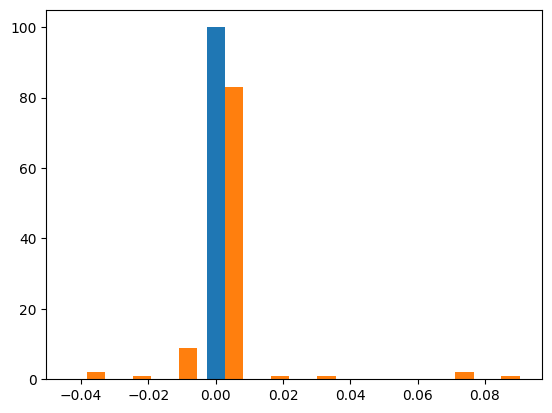

In [ ]:
plt.hist(grad)

Text(0.5, 1.0, 'loss_landscape')

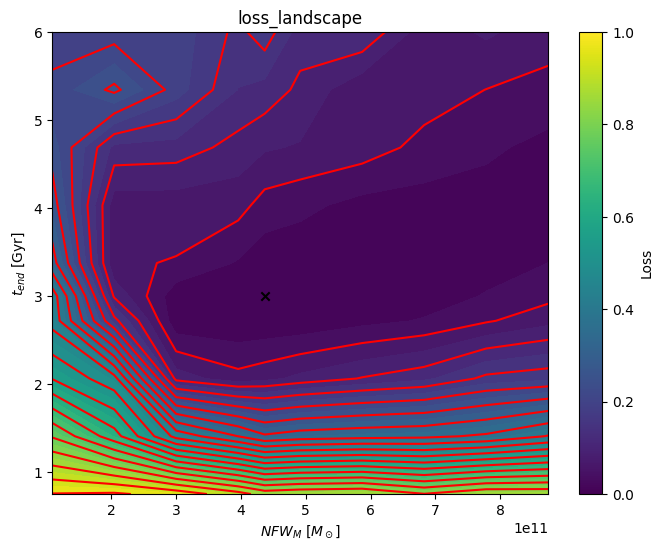

In [ ]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
ax = plt.contourf(M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=50, cmap="viridis")
plt.contour(ax, levels=ax.levels[::2], colors='r')
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="black", marker="x", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss_landscape")
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass_tend_20x20.pdf', dpi=300, bbox_inches='tight')

In [ ]:
grad

(Array([-6.53907484e-13, -2.07786826e-12, -4.75969264e-12, -6.06469042e-12,
        -5.07371922e-12, -2.30214112e-12, -1.06007564e-11, -8.27233247e-12,
        -9.69316294e-12, -1.22697963e-11,  1.21033739e-12, -4.60448346e-12,
        -2.80576673e-11,  2.59139599e-10,  1.16764112e-10,  1.19317933e-09,
         6.80236756e-10, -9.66497371e-09, -6.77165879e-09,  2.01232186e-08,
        -1.38834777e-12,  3.15809219e-11, -3.26836058e-11,  1.65954264e-11,
        -8.81413432e-12,  3.43187950e-10,  1.06880553e-10, -7.83994702e-10,
         3.41582163e-09,  5.74235881e-10, -1.69700365e-12,  4.75918194e-11,
         1.56273883e-11, -5.21579308e-12, -2.33331097e-11, -3.25708661e-11,
         1.73985298e-10, -1.76720749e-10, -2.23026361e-10, -5.91681981e-10,
         1.26391397e-11,  1.12054713e-10,  4.49405305e-11,  2.10046928e-11,
        -1.04966764e-11,  3.46597959e-11,  7.95431776e-12,  3.26591670e-10,
        -6.27248475e-10, -5.83950110e-10,  1.74904535e-11,  3.08708892e-11,
         1.8

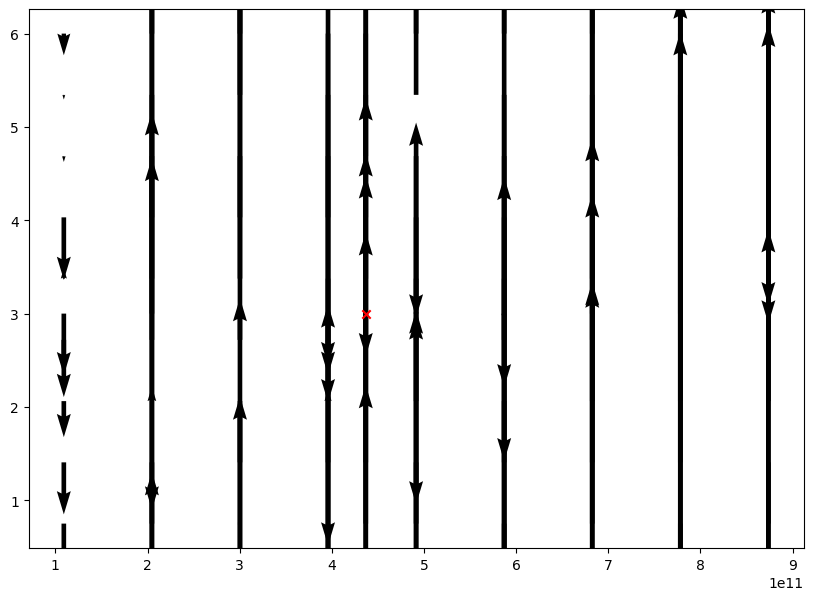

In [ ]:
plt.style.use('default')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, )
vectorf_field = ax.quiver(M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr),
                            grad[0].reshape(M_tot_grid.shape).T, 
                            grad[1].reshape(M_tot_grid.shape).T,
                            scale=0.005,)
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", marker="x", label="True values")


# Plummer scale radius

In [58]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

# @jit
def time_integration_Plummer_a_grad(a, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                Plummer_params=params.Plummer_params._replace(
                    a=a
                ))
    new_params_com = params_com._replace(
                Plummer_params=params_com.Plummer_params._replace(
                    a=a 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.mean(logL_values)/1_000
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mtot = params.Plummer_params.a*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_Plummer_a_grad, )(Mtot, key)
print("Gradient of the total mass of the Plummer:\n", grad)
print("Loss:\n", loss)  



Gradient of the total mass of the Plummer:
 -8.984836
Loss:
 -0.030304013


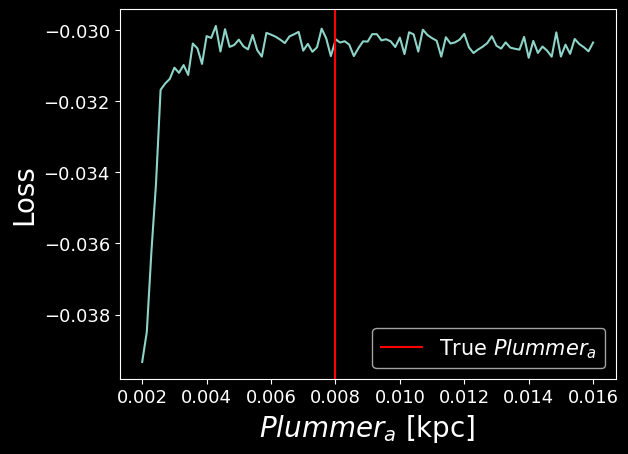

In [59]:
n_sim = 99
keys = jnp.arange(n_sim+1)
a = np.linspace(params.Plummer_params.a*(1/4), params.Plummer_params.a*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
a = np.concatenate([a, np.array([params.Plummer_params.a])]) # Append the true Mvir value
a = jnp.array(np.sort(a))

# mesh = Mesh(np.array(jax.devices()), ("i",))
# a_sharded = jax.device_put(a, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

a_sharded = a
keys_sharded = keys

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_Plummer_a_grad_map(a_and_key):
    a, key = a_and_key
    return jax.value_and_grad(time_integration_Plummer_a_grad)(a, key)

loss, grad = jax.lax.map(
    time_integration_Plummer_a_grad_map, 
    (a_sharded, keys_sharded), 
    batch_size=1
)

plt.figure()
plt.plot(a_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.Plummer_params.a*(code_units.code_length).to(u.kpc), color='r', label='True $Plummer_{a}$')
plt.xlabel("$Plummer_{a}$ [kpc]")
plt.ylabel('Loss')
plt.legend()

(array([ 4., 14., 63., 14.,  0.,  3.,  1.,  0.,  0.,  1.]),
 array([-236.08050537, -136.79544067,  -37.51037598,   61.77468872,
         161.05975342,  260.34481812,  359.62988281,  458.91497803,
         558.20001221,  657.48504639,  756.7701416 ]),
 <BarContainer object of 10 artists>)

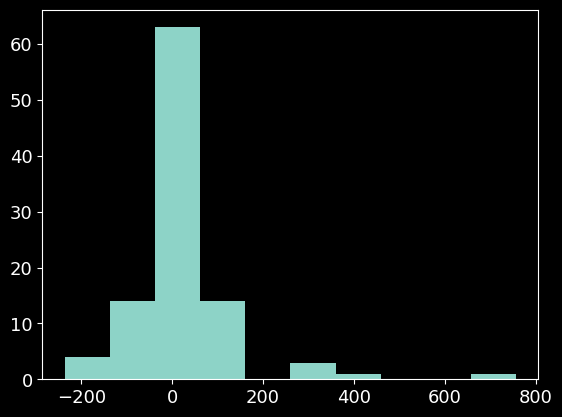

In [60]:
plt.hist(grad)

# Plummer mass

Since it is linked to the single star particle it needs lots of memory to compute


In [61]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


# @jit
def time_integration_Plummer_M_grad(Mtot, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                Plummer_params=params.Plummer_params._replace(
                    Mtot=Mtot
                ))
    new_params_com = params_com._replace(
                Plummer_params=params_com.Plummer_params._replace(
                    Mtot=Mtot 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.mean(logL_values)/1_000
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mtot = params.Plummer_params.Mtot*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_Plummer_M_grad, )(Mtot, key)
print("Gradient of the total mass of the Plummer:\n", grad)
print("Loss:\n", loss)  


Gradient of the total mass of the Plummer:
 0.04857799
Loss:
 -0.030373834


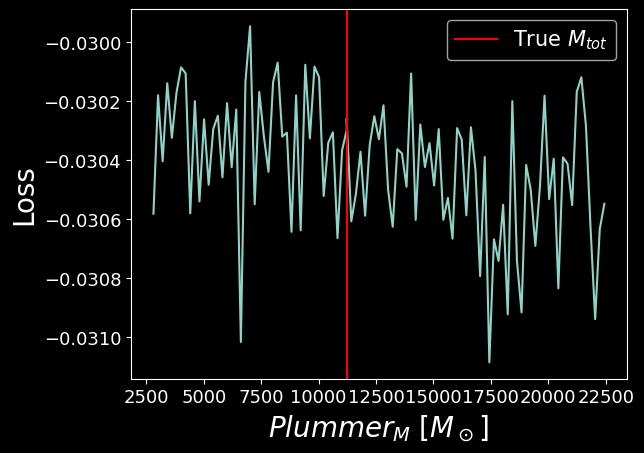

In [62]:
n_sim = 99
keys = jnp.arange(n_sim+1)
Mtot = np.linspace(params.Plummer_params.Mtot*(1/4), params.Plummer_params.Mtot*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
Mtot = np.concatenate([Mtot, np.array([params.Plummer_params.Mtot])]) # Append the true Mvir value
Mtot = jnp.array(np.sort(Mtot))

# mesh = Mesh(np.array(jax.devices()), ("i",))
# Mtot_sharded = jax.device_put(Mtot, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

Mtot_sharded = Mtot
keys_sharded = keys

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_Plummer_M_grad_map(Mtot_and_key):
    Mtot, key = Mtot_and_key
    return jax.value_and_grad(time_integration_Plummer_M_grad)(Mtot, key)

loss, grad = jax.lax.map(
    time_integration_Plummer_M_grad_map, 
    (Mtot_sharded, keys_sharded), 
    batch_size=3
)

plt.figure()
plt.plot(Mtot_sharded*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.Plummer_params.Mtot*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$Plummer_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()

(array([ 1.,  1.,  9., 23., 31., 24.,  8.,  2.,  0.,  1.]),
 array([-0.17390892, -0.13439202, -0.09487511, -0.05535821, -0.01584131,
         0.02367559,  0.0631925 ,  0.10270941,  0.14222631,  0.1817432 ,
         0.22126013]),
 <BarContainer object of 10 artists>)

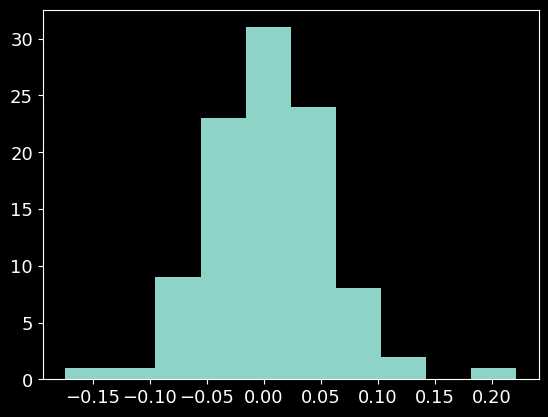

In [64]:
plt.hist(grad)

# Initial position Loss

In [13]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit
def time_integration_xpos_grad(x_pos, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[x_pos, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy

    return loss

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
x_pos = 10.0 * u.kpc.to(code_units.code_length)
key = 0
loss, grad = jax.value_and_grad(time_integration_xpos_grad, )(x_pos, key)
print("Gradient of the x position of the center of mass:\n", grad)
print("Loss:\n", loss)

Gradient of the x position of the center of mass:
 -19426.936
Loss:
 0.44479352


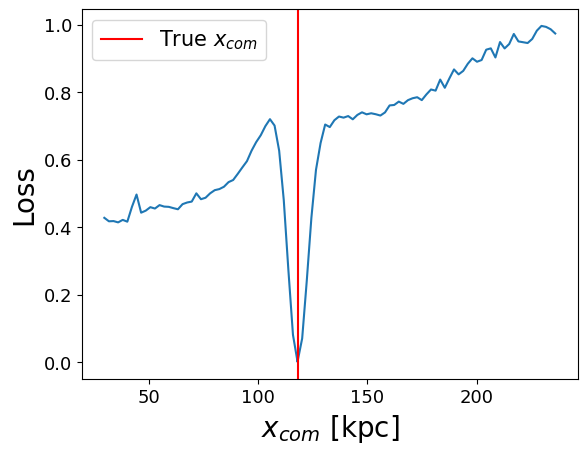

In [14]:
n_sim = 99
keys = jnp.arange(n_sim+1)
x_pos = np.linspace(11.8*(1/4), 11.8*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
x_pos = np.concatenate([x_pos, np.array([11.8])])  # Append the true x position value
x_pos = jnp.array(np.sort(x_pos))
mesh = Mesh(np.array(jax.devices()), ("i",))
x_pos_sharded = jax.device_put(x_pos, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_xpos_grad_map(x_pos_and_key):
    x_pos, key = x_pos_and_key
    return jax.value_and_grad(time_integration_xpos_grad)(x_pos, key)
loss, grad = jax.lax.map(
    time_integration_xpos_grad_map, 
    (x_pos_sharded, keys_sharded), 
    batch_size=1
)
plt.figure()
plt.plot(x_pos_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(11.8*(code_units.code_length).to(u.kpc), color='r', label='True $x_{com}$')
plt.xlabel("$x_{com}$ [kpc]")
plt.ylabel('Loss')
plt.legend()


In [15]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_xy_grad(x_pos, y_pos, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[x_pos, y_pos, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
x_pos = 11.8 * u.kpc.to(code_units.code_length)
y_pos = 0.79 * u.kpc.to(code_units.code_length)
key = 0
loss, grad = jax.value_and_grad(time_integration_xy_grad, )(x_pos, y_pos, key)
print("Gradient of the x and y position of the center of mass:\n", grad)
print("Loss:\n", loss)


Gradient of the x and y position of the center of mass:
 3943013.2
Loss:
 0.4485926


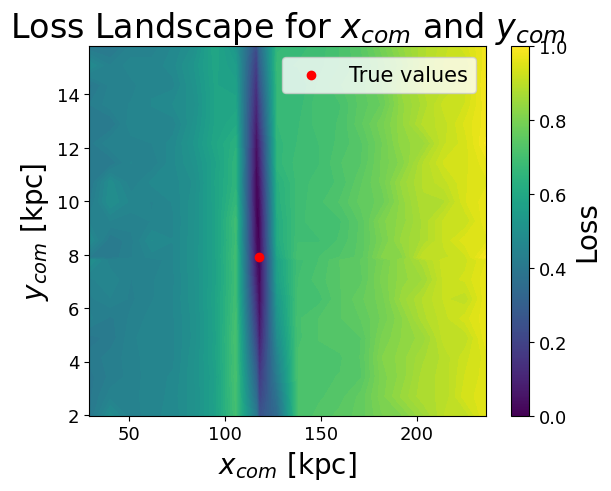

In [16]:
n_sim = 20
keys = jnp.arange(n_sim+1)
x_pos = np.linspace(11.8*(1/4), 11.8*(8/4), n_sim)
y_pos = np.linspace(0.79*(1/4), 0.79*(8/4), n_sim)

x_pos = np.concatenate([x_pos, np.array([11.8])])  # Append the true x position value
y_pos = np.concatenate([y_pos, np.array([0.79])])  # Append the true y position value
x_pos = jnp.array(np.sort(x_pos))
y_pos = jnp.array(np.sort(y_pos))

xx, yy = jnp.meshgrid(x_pos, y_pos, indexing="ij")
# Flatten the grid for vectorized computation
x_pos_flat = xx.flatten()
y_pos_flat = yy.flatten()
keys_flat = jnp.arange(len(x_pos_flat))  # Create a flat array of keys
mesh = Mesh(np.array(jax.devices()), ("i",))
x_pos_sharded = jax.device_put(x_pos_flat, NamedSharding(mesh, PartitionSpec("i")))
y_pos_sharded = jax.device_put(y_pos_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))
@jit
def time_integration_xy_grad_map(xy_and_key):
    x_pos, y_pos, key = xy_and_key
    return jax.value_and_grad(time_integration_xy_grad)(x_pos, y_pos, key)
loss, grad = jax.lax.map(
    time_integration_xy_grad_map, 
    (x_pos_sharded, y_pos_sharded, keys_sharded), 
    batch_size=1
)

plt.figure()
plt.contourf(xx*(code_units.code_length).to(u.kpc), 
             yy*(code_units.code_length).to(u.kpc), 
             loss.reshape(xx.shape), levels=100, cmap="viridis")
plt.scatter(11.8*(code_units.code_length).to(u.kpc), 0.79*(code_units.code_length).to(u.kpc), color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$x_{com}$ [kpc]")
plt.ylabel("$y_{com}$ [kpc]")
plt.title("Loss Landscape for $x_{com}$ and $y_{com}$")
plt.legend()

# Initial Velocity Loss

In [17]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_vx_grad(vx_com, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[vx_com,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
vx_com = 109.5 * (3/4) * (u.km/u.s).to(code_units.code_velocity)
key = 0
loss, grad = jax.value_and_grad(time_integration_vx_grad, )(vx_com, key)
print("Gradient of the x velocity of the center of mass:\n", grad)

Gradient of the x velocity of the center of mass:
 -0.0015706393


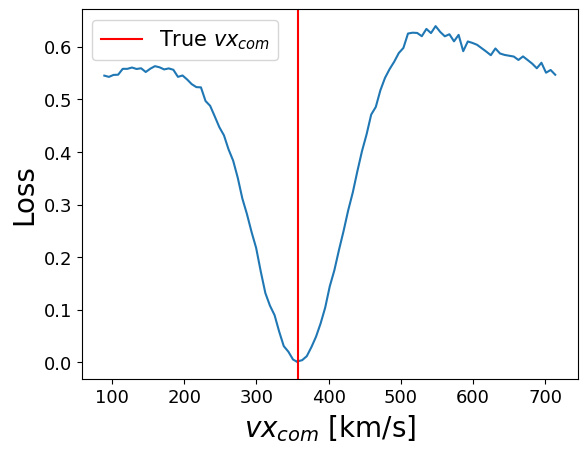

In [18]:
n_sim = 99
keys = jnp.arange(n_sim+1)
vx_com = np.linspace(109.5*(1/4), 109.5*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
vx_com = np.concatenate([vx_com, np.array([109.5])])  # Append the true vx_com value
vx_com = jnp.array(np.sort(vx_com))
mesh = Mesh(np.array(jax.devices()), ("i",))
vx_com_sharded = jax.device_put(vx_com, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

@jit
def time_integration_vx_grad_map(vx_com_and_key):
    vx_com, key = vx_com_and_key
    return jax.value_and_grad(time_integration_vx_grad)(vx_com, key)
loss, grad = jax.lax.map(
    time_integration_vx_grad_map, 
    (vx_com_sharded, keys_sharded), 
    batch_size=1
)
plt.figure()
plt.plot(vx_com_sharded*(code_units.code_velocity).to(u.km/u.s), loss)
plt.axvline(109.5*(code_units.code_velocity).to(u.km/u.s), color='r', label='True $vx_{com}$')
plt.xlabel("$vx_{com}$ [km/s]")
plt.ylabel('Loss')
plt.legend()